คราวนี้เราจะมาลองสร้าง Dataset ของตัวเอง เพื่อเทรนโมเดล 

* Eczema โรคผิวหนังอักเสบ โรคแพ้ผื่นคัน
* Psoriasis โรคสะเก็ดเงิน
* Acne Vulgaris โรคสิว โรคสิวธรรมดา
* Rosacea โรคผิวหนังอักเสบโรซาเชีย

# 0. Magic Commands


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล



In [14]:
folder = 'eczema'
file = 'urls_eczema.txt'

In [18]:
folder = 'psoriasis'
file = 'urls_psoriasis.txt'

In [22]:
folder = 'acne'
file = 'urls_acne.txt'

In [26]:
folder = 'rosacea'
file = 'urls_rosacea.txt'

Create folder and download all pictures in urls

In [27]:
path = Path('data/skin')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [28]:
classes = ['eczema','psoriasis','acne', 'rosacea']

In [29]:
download_images(path/file, dest, max_pics=500)

In [30]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# 3. เตรียมข้อมูล

เพิ่มขนาดรูปจาก 224 เป็น 299 และลดขนาด batch size เหลือ 64 เนื่องจากโมเดลที่ขนาดใหญ่ขึ้น มีความต้องการ Memory ที่มากขึ้น ถ้าใช้ Batch Size เท่าเดิมจะทำให้ Error GPU Out of Memory ได้

In [31]:
batchsize = 64
np.random.seed(0)

databunch = ImageDataBunch.from_folder(path, train='.', 
                                       valid_pct=0.2, 
                                       ds_tfms=get_transforms(), 
                                       size=224, bs=batchsize).normalize(imagenet_stats)

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label ชื่อพันธุ์ไว้บนรูป แสดง 3 แถว (rows) ในกรอบขนาด 12 x 9 นิ้ว (figsize)

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [35]:
databunch.classes

['acne', 'eczema', 'psoriasis', 'rosacea']

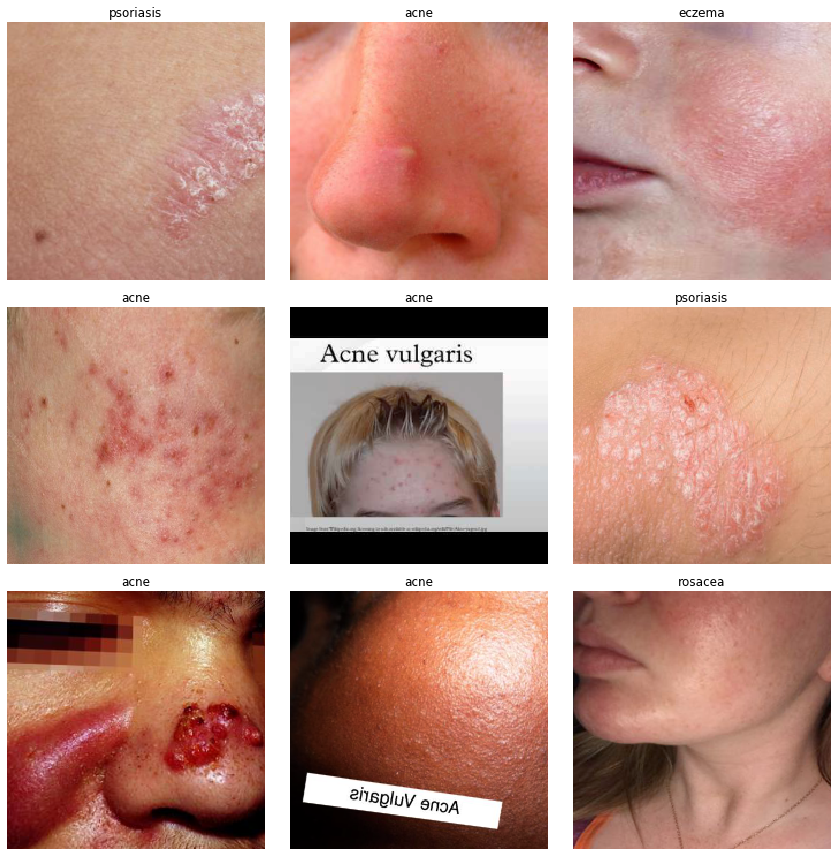

In [36]:
databunch.show_batch(rows=3, figsize=(12, 12))

In [37]:
databunch.classes, databunch.c, len(databunch.train_ds), len(databunch.valid_ds)

(['acne', 'eczema', 'psoriasis', 'rosacea'], 4, 1548, 386)

# 4. สร้างโมเดล

เปลี่ยนจาก models.resnet34 เป็น models.resnet50

In [38]:
learner = cnn_learner(databunch, models.resnet34, metrics=accuracy)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 8 Cycle

In [ ]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time


เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [7]:
learner.save('01d-resnet34-1')

โหลดโมเดลที่เรา Save ไว้ ขึ้นมาใหม่ เตรียมเทรนในขึ้นตอนถัดไป (ที่คอมเม้นท์ไว้ เพราะถ้าไม่ได้เปลี่ยนอะไรก็จะได้ไม่ต้องรัน)

In [8]:
# learner.load('resnet50-1')

# 6. เทรนต่อ

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


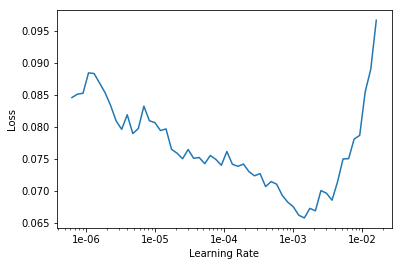

In [9]:
learner.lr_find()
learner.recorder.plot()

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

In [10]:
learner.unfreeze()
learner.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.084617,0.155998,0.945196,01:06
1,0.076518,0.151621,0.948579,01:03
2,0.064865,0.151930,0.951286,01:03


## สำเร็จแล้ว ##

เพียงแค่เวลา 10 นาทีเศษ เราเทรน Model ได้ accuracy ประมาณ 0.95 หรือ ความแม่นยำประมาณ 95%

เปรียบเทียบกับ 94.0% จาก ResNet34 ที่เราเทรนครั้งก่อน 

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [11]:
learner.save('01d-resnet34-2')

# 7. ดูผลลัพธ์

In [12]:
interpretation = ClassificationInterpretation.from_learner(learner)

เรียกดู most_confused คือ พันธุ์ที่โมเดลทายผิดมากที่สุดเรียงลงไป

In [13]:
interpretation.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('Ragdoll', 'Birman', 7),
 ('Siamese', 'Birman', 4),
 ('miniature_pinscher', 'chihuahua', 4),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Maine_Coon', 'Persian', 2),
 ('boxer', 'american_pit_bull_terrier', 2),
 ('miniature_pinscher', 'staffordshire_bull_terrier', 2),
 ('shiba_inu', 'Maine_Coon', 2)]

# 8. สรุป


เปรียบเทียบกับเคสก่อนที่ใช้ ResNet34 กับ เคสนี้เราใช้ ResNet50 

* โมเดลใช้เวลาในการเทรนนานขึ้น จาก 3 นาที เป็น 10 นาที
* ใช้ memory GPU มากขึ้น 
* ประสิทธิภาพความแม่นยำดีขึ้น ประมาณ 1%

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 1](https://course.fast.ai/videos/?lesson=1)